In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
X = fetch_adult()
X

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


WeightedDataset(X=                   age     workclass     education  education-num  \
race      sex                                                       
Non-white Male    25.0       Private          11th            7.0   
White     Male    38.0       Private       HS-grad            9.0   
          Male    28.0     Local-gov    Assoc-acdm           12.0   
Non-white Male    44.0       Private  Some-college           10.0   
White     Male    34.0       Private          10th            6.0   
...                ...           ...           ...            ...   
          Female  27.0       Private    Assoc-acdm           12.0   
          Male    40.0       Private       HS-grad            9.0   
          Female  58.0       Private       HS-grad            9.0   
          Male    22.0       Private       HS-grad            9.0   
          Female  52.0  Self-emp-inc       HS-grad            9.0   

                      marital-status         occupation   relationship   race  \
rac

In [3]:
def load_adult():
    data_df = pd.read_csv(f"adult.csv")
    # Drop the target column
    TARGET_COLUMNS = data_df.columns[-1]
    data = data_df.drop(columns=[TARGET_COLUMNS])

    data, numeric_columns, categorical_columns = preprocess_dataset(data, continuous_features=[])
    data_df_copy = data.copy()
    # Scale the dataset
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(data_scaled, columns=data.columns)

    FEATURE_COLUMNS = data.columns

    # Add the target column back
    data[TARGET_COLUMNS] = data_df[TARGET_COLUMNS]

    return data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns

In [4]:
def preprocess_dataset(df, continuous_features=[]):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()

    numeric_columns = []
    categorical_columns = []

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Check if the column is categorical
        if df[col].dtype == 'object' or df[col].dtype == 'category' and col not in continuous_features:
            categorical_columns.append(col)
            # If the column has only two unique values, treat it as binary categorical
            if len(df[col].unique()) == 2:
                # Label encode binary categorical features
                df[col] = label_encoder.fit_transform(df[col])
            else:
                # One-hot encode regular categorical features
                encoded_values = onehot_encoder.fit_transform(df[[col]])
                # Create new column names for the one-hot encoded features
                new_cols = [col + '_' + str(i) for i in range(encoded_values.shape[1])]
                # Convert the encoded values to a DataFrame and assign column names
                encoded_df = pd.DataFrame(encoded_values.toarray(), columns=new_cols)
                # Concatenate the encoded DataFrame with the original DataFrame
                df = pd.concat([df, encoded_df], axis=1)
                # Drop the original categorical column from the DataFrame
                df.drop(col, axis=1, inplace=True)
        # If the column is numerical but in string format and not in continuous_features, convert it to numerical type
        elif df[col].dtype == 'object' or df[col].dtype == 'category' and df[
            col].str.isnumeric().all() and col not in continuous_features:
            df[col] = df[col].astype(int)  # Convert to integer type
            categorical_columns.append(col)
        # If the column is a continuous feature, discretize it into bins
        elif col in continuous_features:
            numeric_columns.append(col)
            # Calculate the number of bins
            num_unique_values = len(df[col].unique())
            value_range = df[col].max() - df[col].min()
            num_bins = calculate_num_bins(num_unique_values, value_range)

            # Discretize into bins
            bin_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform')
            bins = bin_discretizer.fit_transform(df[[col]])
            # Replace the original continuous feature with the binned values
            df[col] = bins.astype(int)
        else:
            # Here are numerical columns. If the column has only 2 unique values, dont add it to numeric_columns
            if len(df[col].unique()) > 2:
                numeric_columns.append(col)
    return df, numeric_columns, categorical_columns

In [5]:
data = load_adult()
data

(            age  workclass  education  education-num  marital-status  \
 0      0.301370      0.875   0.600000       0.800000        0.666667   
 1      0.452055      0.750   0.600000       0.800000        0.333333   
 2      0.287671      0.500   0.733333       0.533333        0.000000   
 3      0.493151      0.500   0.066667       0.400000        0.333333   
 4      0.150685      0.500   0.600000       0.800000        0.333333   
 ...         ...        ...        ...            ...             ...   
 48837  0.301370      0.500   0.600000       0.800000        0.000000   
 48838  0.643836      0.000   0.733333       0.533333        1.000000   
 48839  0.287671      0.500   0.600000       0.800000        0.333333   
 48840  0.369863      0.500   0.600000       0.800000        0.000000   
 48841  0.246575      0.625   0.600000       0.800000        0.333333   
 
        occupation  relationship  race  sex  capital-gain  capital-loss  \
 0        0.071429           0.2  1.00  1.0    

In [6]:
data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns = load_adult()

print(data.columns)

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'target'],
      dtype='object')


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics_and_split_data(data, features, target, classifier_type='logistic_regression',
                                     metrics=['accuracy'], attribute=None, protected_attribute='sex'):
    """
    Train a classifier, predict on test data, calculate specified metrics from the confusion matrix,
    and optionally split the test data based on an attribute.

    :param data: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param classifier_type: Type of classifier ('logistic_regression', 'svm', 'random_forest', 'naive_bayes')
    :param metrics: List of metrics to calculate ('accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn')
    :param attribute: Optional attribute to split the test data on, which should be binary (0 or 1)
    :param protected_attribute: Name of the protected attribute to optionally reference (default is 'sex')
    :return: Dictionary of requested metrics, optionally two DataFrames (one for each value of the attribute),
             and the trained model instance.
    """
    
    # Step 1: Keep all features, including the protected attribute
    features_with_protected = features  # No filtering of the protected attribute
    
    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[features_with_protected], data[target], test_size=0.2, random_state=42)

    # Debugging: Print the shape of the train and test sets
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Initialize classifier
    classifiers = {
        'logistic_regression': LogisticRegression(max_iter=500, solver='saga'),
        'svm': SVC(),
        'random_forest': RandomForestClassifier(),
        'naive_bayes': GaussianNB()
    }
    classifier = classifiers[classifier_type]

    # Fit the classifier and predict
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]  # True Positives
    tn = cm[0, 0]  # True Negatives
    fp = cm[0, 1]  # False Positives
    fn = cm[1, 0]  # False Negatives

    # Debugging: Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics_dict = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

    # Print accuracy
    print(f"Accuracy: {metrics_dict['accuracy']}")

    # Validate metrics
    results = {}
    for metric in metrics:
        if metric not in metrics_dict:
            raise ValueError(
                f"Unsupported metric '{metric}'. Choose from 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn'.")
        results[metric] = metrics_dict[metric]

    # Step 3: Add the target column back to the test set for completeness
    X_test_df = X_test.copy()
    X_test_df[target] = y_test.values
    X_test_df['pred'] = y_pred
    
    # Step 4: Separate True Negatives (TN) and False Negatives (FN)
    tn_df = X_test_df[(X_test_df[target] == 0) & (X_test_df['pred'] == 0)]  # True Negatives
    fn_df = X_test_df[(X_test_df[target] == 1) & (X_test_df['pred'] == 0)]  # False Negatives

    # Return the metrics, test DataFrame, classifier, and separated TN and FN DataFrames
    return results, X_test_df, classifier, tn_df, fn_df

Training data shape: X_train: (39073, 12), y_train: (39073,)
Testing data shape: X_test: (9769, 12), y_test: (9769,)
Confusion Matrix:
[[1024 1331]
 [ 397 7017]]
Accuracy: 0.8231139318251612
Generating heatmaps for 5 random True Negatives (TN):


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]

Counterfactuals for TN index 44338:


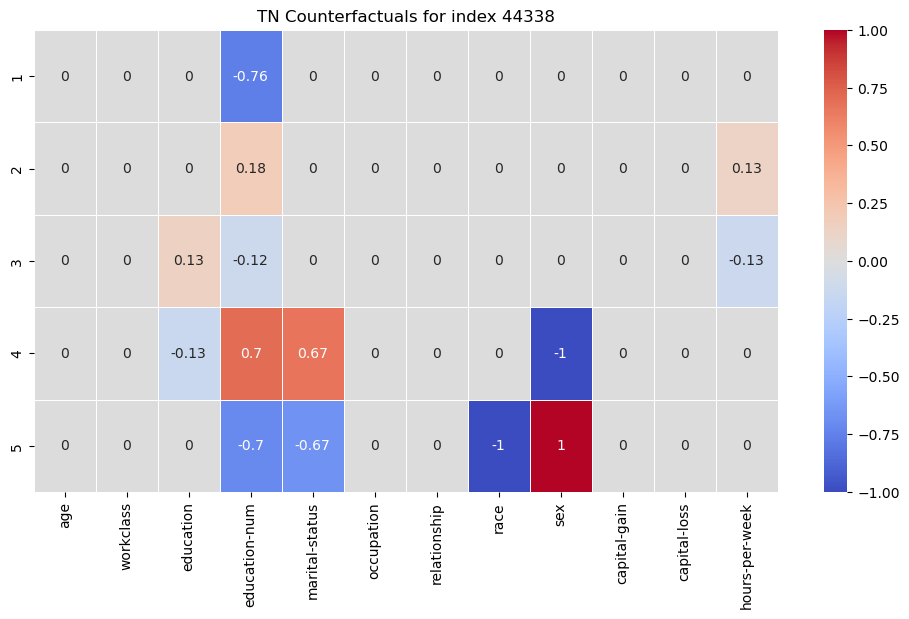

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


Counterfactuals for TN index 42834:


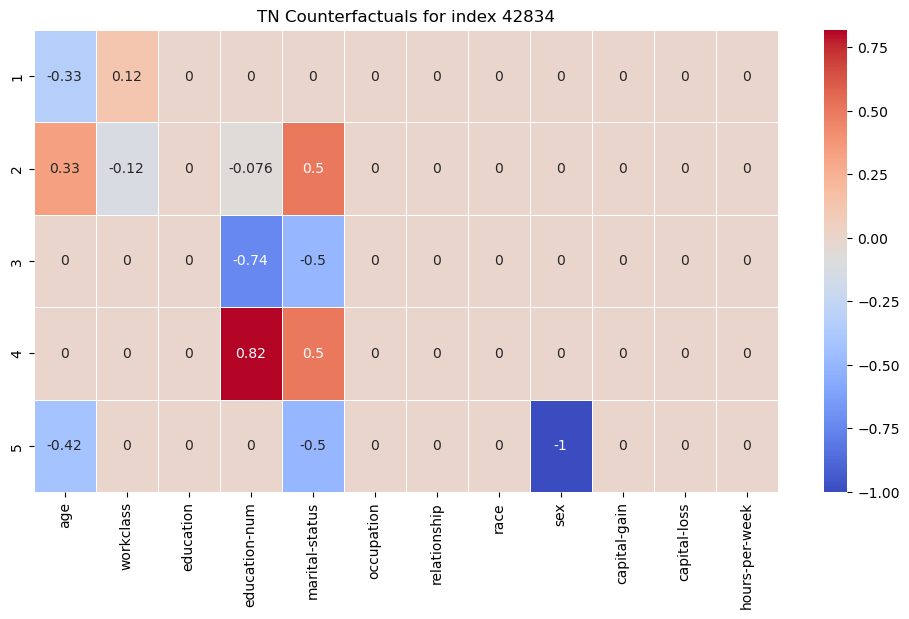

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Counterfactuals for TN index 32533:


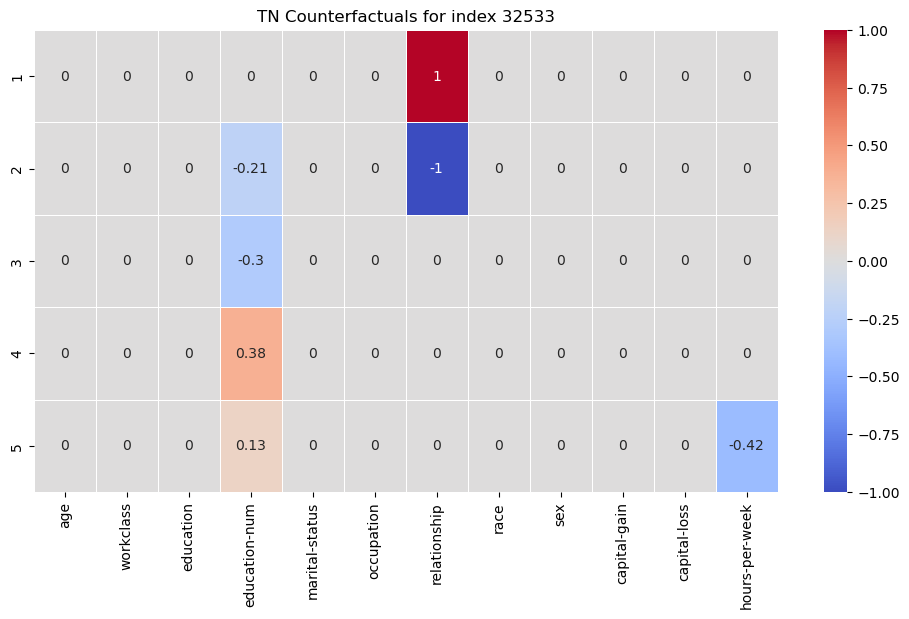

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


Counterfactuals for TN index 27722:


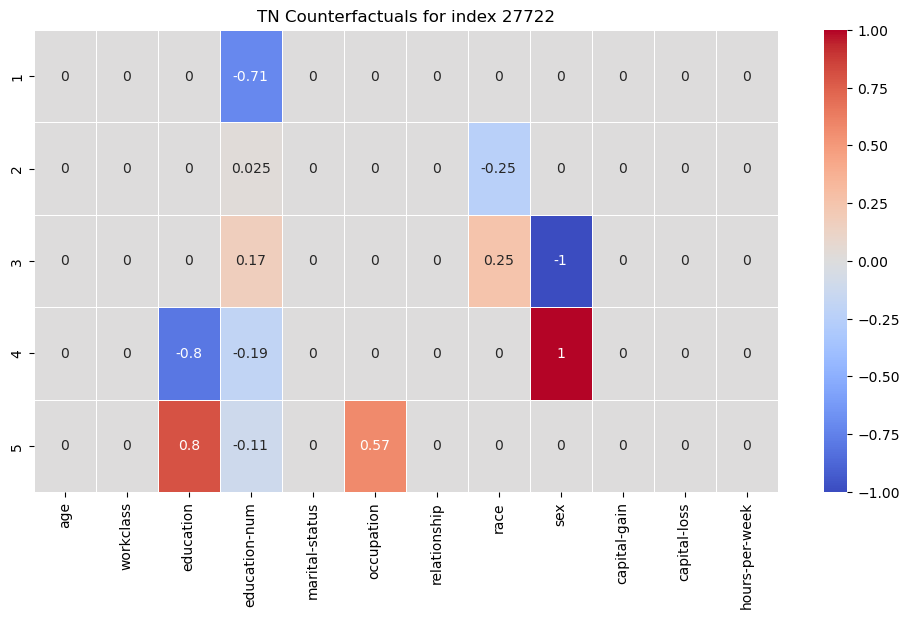

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Counterfactuals for TN index 33280:


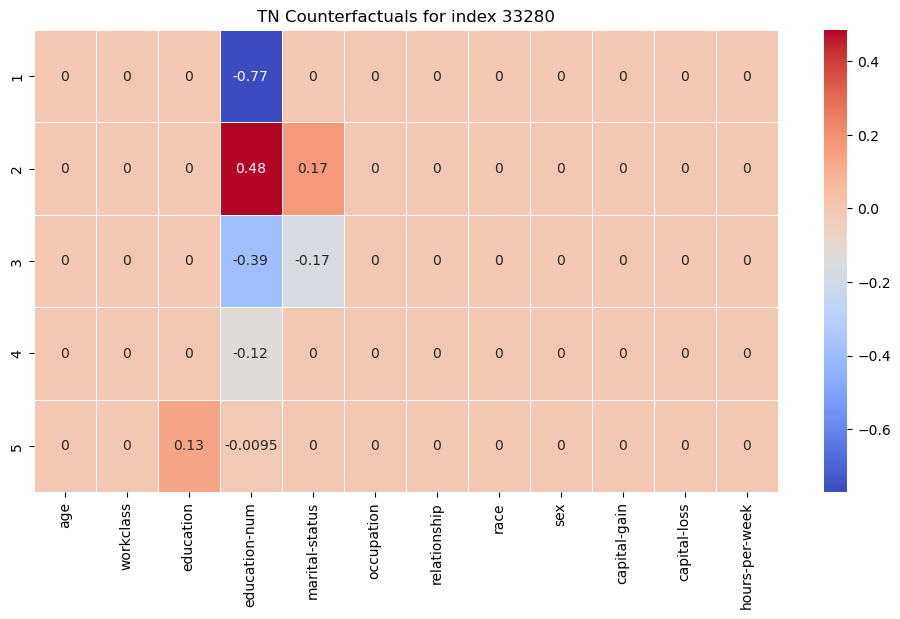

Generating heatmaps for 5 random False Negatives (FN):


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.14it/s]

Counterfactuals for FN index 36747:


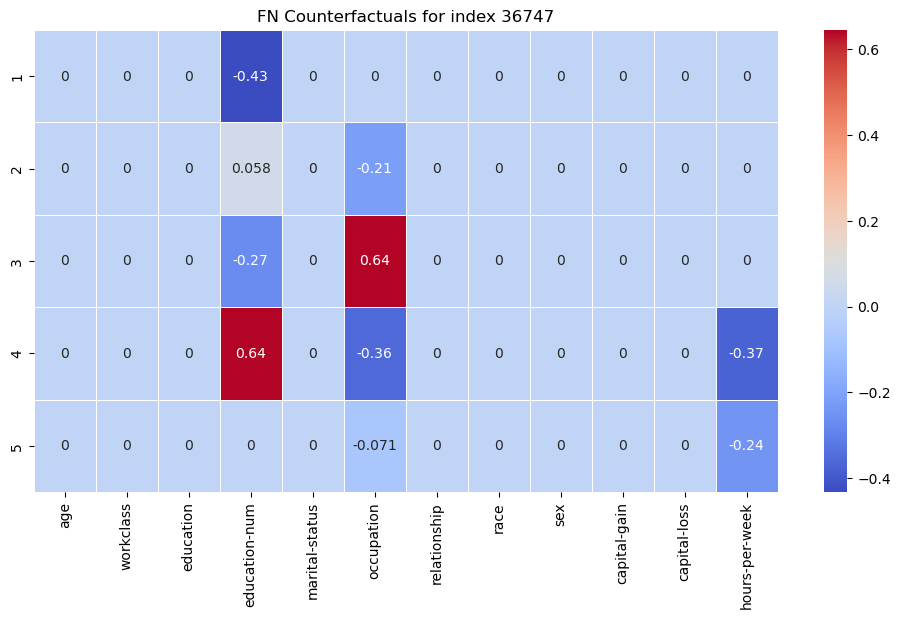

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


Counterfactuals for FN index 15521:


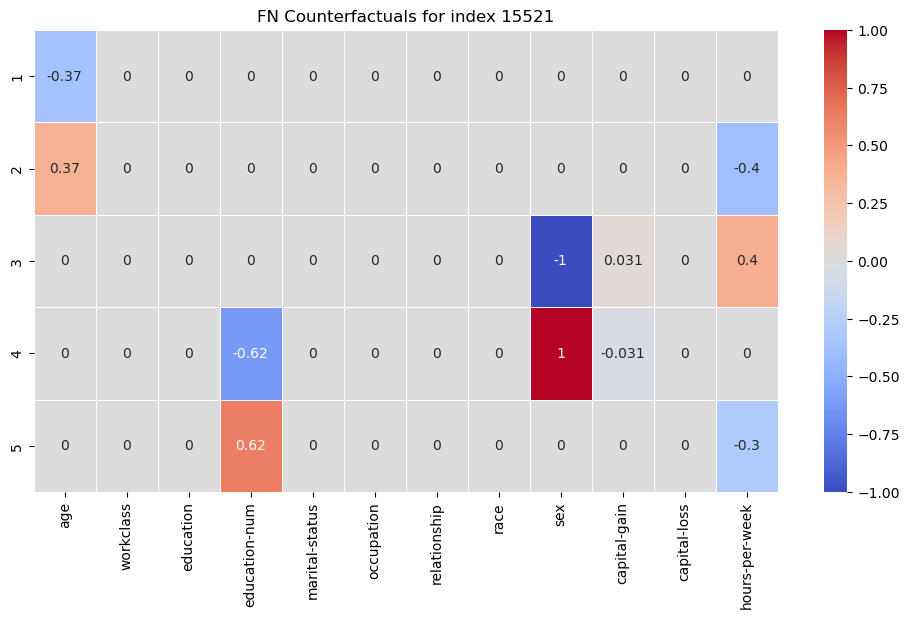

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.07it/s]


Counterfactuals for FN index 43556:


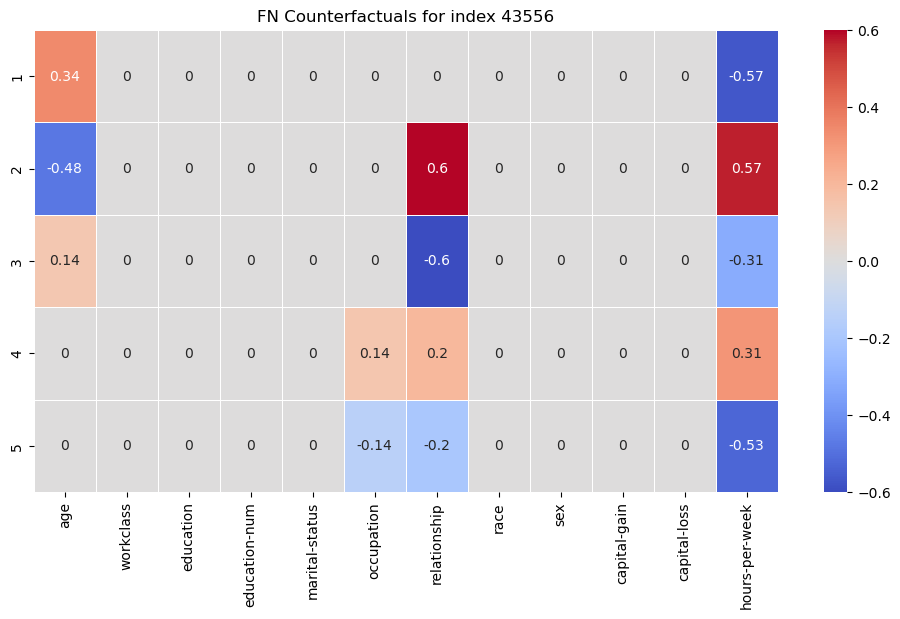

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]

Counterfactuals for FN index 10544:


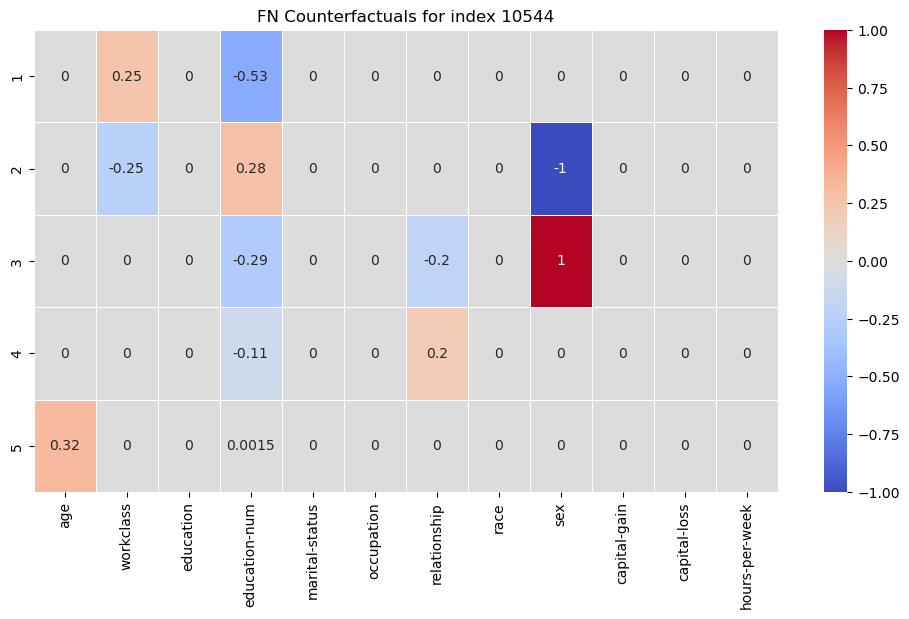

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it]

Counterfactuals for FN index 31142:


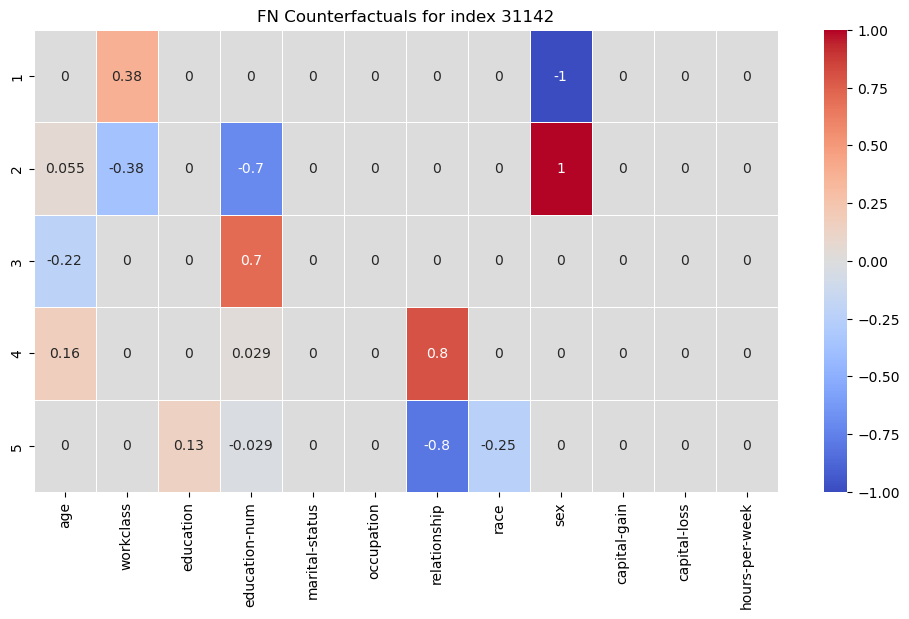

In [12]:
import dice_ml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Load the dataset and preprocess without the protected attribute
data, features, target, numeric_columns, categorical_columns = load_adult()


# Step 2: Train the model and get TN and FN DataFrames
results, test_df, trained_model, tn_df, fn_df = calculate_metrics_and_split_data(
    data, features, target, classifier_type='logistic_regression', protected_attribute='sex')


# Set up DiceML without the 'sex' attribute
d = dice_ml.Data(dataframe=data, continuous_features=["education-num", "hours-per-week"], outcome_name=target)
m = dice_ml.Model(model=trained_model, backend="sklearn")
explainer = dice_ml.Dice(d, m, method="random")

features_to_vary = [col for col in features if col != target]  # Adjust this list as needed

# Function to generate heatmap of changes for a given set of samples
def plot_counterfactual_heatmap(original_instance, cf_instance, title):
    # Concatenate original instance with counterfactuals
    all_data = pd.concat([original_instance] + [cf_instance], axis=0).reset_index(drop=True)
    # Calculate the difference between original and counterfactuals
    delta = all_data.diff().iloc[1:]  # Take differences from the second row onwards
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(delta, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title(title)
    plt.show()

# Step 5: Generate counterfactuals for 5 random True Negatives (TN) and create heatmaps
print("Generating heatmaps for 5 random True Negatives (TN):")
tn_sample = tn_df.sample(n=5, random_state=42)  # Select 5 random TN samples

for idx, row in tn_sample.iterrows():
    input_datapoint_tn = row.drop(labels=[target, 'pred']).to_frame().T  # Convert series to DataFrame
    cf_tn = explainer.generate_counterfactuals(input_datapoint_tn, total_CFs=5, desired_class=1, features_to_vary=features_to_vary)
    
    # Convert counterfactuals to a DataFrame
    cf_tn_df = cf_tn.cf_examples_list[0].final_cfs_df[features_to_vary]
    
    # Plot heatmap for this instance
    print(f"Counterfactuals for TN index {idx}:")
    plot_counterfactual_heatmap(input_datapoint_tn[features_to_vary], cf_tn_df, f"TN Counterfactuals for index {idx}")

# Step 6: Generate counterfactuals for 5 random False Negatives (FN) and create heatmaps
print("Generating heatmaps for 5 random False Negatives (FN):")
fn_sample = fn_df.sample(n=5, random_state=42)  # Select 5 random FN samples

for idx, row in fn_sample.iterrows():
    input_datapoint_fn = row.drop(labels=[target, 'pred']).to_frame().T  # Convert series to DataFrame
    cf_fn = explainer.generate_counterfactuals(input_datapoint_fn, total_CFs=5, desired_class=1, features_to_vary=features_to_vary)
    
    # Convert counterfactuals to a DataFrame
    cf_fn_df = cf_fn.cf_examples_list[0].final_cfs_df[features_to_vary]
    
    # Plot heatmap for this instance
    print(f"Counterfactuals for FN index {idx}:")
    plot_counterfactual_heatmap(input_datapoint_fn[features_to_vary], cf_fn_df, f"FN Counterfactuals for index {idx}")